<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%9C%A0%EC%A0%84%EC%B2%B4_%EC%A0%95%EB%B3%B4_%ED%92%88%EC%A2%85_%EB%B6%84%EB%A5%98_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

유전체 정보 품종 분류 AI 경진대회

https://dacon.io/competitions/official/236035/overview/description

In [45]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 21 kB/s 


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/유전체/open (2).zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/데이콘/유전체/open (2).zip
  inflating: sample_submission.csv   
  inflating: snp_info.csv            
  inflating: test.csv                
  inflating: train.csv               


In [8]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      262 non-null    object
 1   father  262 non-null    int64 
 2   mother  262 non-null    int64 
 3   gender  262 non-null    int64 
 4   trait   262 non-null    int64 
 5   SNP_01  262 non-null    object
 6   SNP_02  262 non-null    object
 7   SNP_03  262 non-null    object
 8   SNP_04  262 non-null    object
 9   SNP_05  262 non-null    object
 10  SNP_06  262 non-null    object
 11  SNP_07  262 non-null    object
 12  SNP_08  262 non-null    object
 13  SNP_09  262 non-null    object
 14  SNP_10  262 non-null    object
 15  SNP_11  262 non-null    object
 16  SNP_12  262 non-null    object
 17  SNP_13  262 non-null    object
 18  SNP_14  262 non-null    object
 19  SNP_15  262 non-null    object
 20  class   262 non-null    object
dtypes: int64(4), object(17)
memory usage: 43.1+ KB


In [4]:
train.head()

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C


In [5]:
snp_info = pd.read_csv('/content/snp_info.csv')

In [6]:
snp_info

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


In [7]:
train.describe()

,father,mother,gender,trait
count,262.0,262.0,262.0,262.000000
mean,0.0,0.0,0.0,1.736641
std,0.0,0.0,0.0,0.441298
min,0.0,0.0,0.0,1.000000
25%,0.0,0.0,0.0,1.000000
50%,0.0,0.0,0.0,2.000000
75%,0.0,0.0,0.0,2.000000
max,0.0,0.0,0.0,2.000000


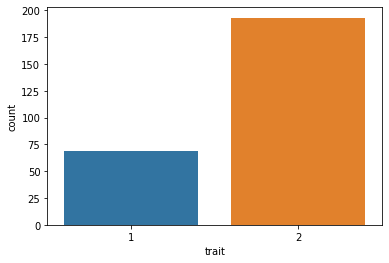

In [13]:
sns.countplot(data=train, x='trait')

In [14]:
train.describe(include='object')

,id,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
count,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262,262
unique,262,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
top,TRAIN_000,G G,G G,A A,A A,A A,A G,A A,G A,A A,G G,A G,A A,G G,A A,A A,B
freq,1,141,108,122,120,94,122,163,96,182,151,96,136,115,185,107,114


In [16]:
train.columns

Index(['id', 'father', 'mother', 'gender', 'trait', 'SNP_01', 'SNP_02',
       'SNP_03', 'SNP_04', 'SNP_05', 'SNP_06', 'SNP_07', 'SNP_08', 'SNP_09',
       'SNP_10', 'SNP_11', 'SNP_12', 'SNP_13', 'SNP_14', 'SNP_15', 'class'],
      dtype='object')

In [ ]:
plt.figure(figsize=(20,20))
for i, col in enumerate(train.columns[5:]):
    plt.subplot(4,4,i+1)
    sns.countplot(data=train, x=col)
plt.show()

# data_f

In [40]:
train_x = train.drop(['id', 'father', 'mother', 'gender'], axis=1)
test_x = test.drop(['id', 'father', 'mother', 'gender'], axis=1)
train_y = train_x.pop('class')

In [41]:
train_x['trait'] = train_x['trait'].apply(str)
test_x['trait'] = test_x['trait'].apply(str)

In [42]:
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

In [38]:
train_x

,trait_1,trait_2,SNP_01_A A,SNP_01_A G,SNP_01_G G,SNP_02_A A,SNP_02_A G,SNP_02_G G,SNP_03_A A,SNP_03_C A,...,SNP_12_G G,SNP_13_A A,SNP_13_A G,SNP_13_G G,SNP_14_A A,SNP_14_C A,SNP_14_C C,SNP_15_A A,SNP_15_G A,SNP_15_G G
0,0,1,0,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1,0,1,0,1,0,0,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0
3,1,0,1,0,0,0,0,1,1,0,...,1,0,0,1,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0,1,0,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
258,0,1,0,0,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
259,1,0,0,1,0,0,0,1,1,0,...,1,0,0,1,0,1,0,0,0,1
260,1,0,1,0,0,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,1


# model_se

In [47]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, stratify=train_y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((235, 47), (27, 47), (235,), (27,))

In [64]:
knc = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
cat = CatBoostClassifier(verbose=0)
models = [knc, svc, rfc, xgb, lgbm, cat]
for i in models:
    model = i.fit(train_x, train_y)
    sc = round(model.score(train_x, train_y), 2)
    pre = model.predict(val_x)
    f1 = round(f1_score(val_y, pre, average='macro'), 2)
    print('='*10, i.__class__.__name__, '='*10)
    print(f'sc : {sc}, f1 : {f1}')

========== KNeighborsClassifier ==========
sc : 0.96, f1 : 1.0
========== SVC ==========
sc : 0.98, f1 : 0.97
========== RandomForestClassifier ==========
sc : 1.0, f1 : 1.0
========== XGBClassifier ==========
sc : 1.0, f1 : 0.97
========== LGBMClassifier ==========
sc : 1.0, f1 : 0.97
========== CatBoostClassifier ==========
sc : 1.0, f1 : 1.0


In [57]:
model = cat.fit(train_x, train_y)
pre = model.predict_proba(test_x)

In [65]:
voc = VotingClassifier([('knc' , knc), ('svc', svc), ('rfc', rfc), ('xgb', xgb), ('lgbm', lgbm), ('cat', cat)], voting='soft')
model = voc.fit(train_x, train_y)
pre = model.predict(test_x)

In [66]:
pre

array(['A', 'B', 'C', 'B', 'A', 'B', 'C', 'B', 'A', 'A', 'C', 'B', 'B',
       'A', 'B', 'B', 'A', 'B', 'B', 'C', 'B', 'B', 'B', 'A', 'B', 'B',
       'B', 'A', 'A', 'B', 'A', 'A', 'B', 'C', 'A', 'B', 'C', 'B', 'B',
       'C', 'A', 'B', 'C', 'B', 'B', 'B', 'B', 'C', 'B', 'C', 'A', 'B',
       'A', 'B', 'B', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'C', 'C',
       'A', 'B', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'C', 'B', 'C', 'B',
       'B', 'B', 'C', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'A', 'B',
       'B', 'C', 'B', 'B', 'C', 'A', 'B', 'A', 'C', 'A', 'B', 'B', 'C',
       'A', 'A', 'C', 'B', 'A', 'B', 'C', 'B', 'B', 'B', 'B', 'A', 'A',
       'C', 'B', 'B', 'A', 'B', 'B', 'C', 'C', 'B', 'B', 'B', 'A', 'B',
       'A', 'A', 'B', 'B', 'B', 'C', 'A', 'A', 'B', 'A', 'A', 'A', 'C',
       'B', 'B', 'B', 'A', 'B', 'C', 'A', 'A', 'B', 'A', 'B', 'B', 'A',
       'A', 'B', 'C', 'A', 'B', 'C', 'C', 'B', 'A', 'A', 'C', 'B', 'B',
       'A', 'B', 'C', 'C', 'B', 'B'], dtype=object)

In [67]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['class'] = pre
sub.to_csv('sub.csv', index=False)

# dnn

In [86]:
train_y_oh = pd.get_dummies(train_y)

In [95]:
classes = train_y_oh.columns

In [84]:
def make_model():
    inputs = layers.Input(shape=(47))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [80]:
model = make_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 47)]              0         
                                                                 
 dense_8 (Dense)             (None, 256)               12288     
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                           

In [89]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.AUC()])
eary_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

his = model.fit(train_x, train_y_oh.values, epochs=100, validation_split=0.1, callbacks=[eary_stop, lr_rate], batch_size=16)

Epoch 1/100
14/14 [==============================] - 3s 39ms/step - loss: 0.9690 - auc_8: 0.7690 - val_loss: 0.8604 - val_auc_8: 0.9149 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4120 - auc_8: 0.9533 - val_loss: 0.7250 - val_auc_8: 0.9401 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2536 - auc_8: 0.9826 - val_loss: 0.6513 - val_auc_8: 0.9614 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.1955 - auc_8: 0.9896 - val_loss: 0.5945 - val_auc_8: 0.9661 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2214 - auc_8: 0.9857 - val_loss: 0.5455 - val_auc_8: 0.9644 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.1539 - auc_8: 0.9939 - val_loss: 0.4966 - val_auc_8: 0.9696 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 0.1177 - auc_8: 0.9964 - val_loss: 0.4

In [92]:
pre = model.predict(test_x)

6/6 [==============================] - 0s 3ms/step


In [94]:
pree = np.argmax(pre, axis=1)

In [97]:
pre_dnn = []
for i in pree:
    pre_dnn.append(classes[i])

In [99]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['class'] = pre_dnn
sub.to_csv('sub.csv', index=False)